# Esame di Analisi Dati in Fisica Subnucleare 2022-09-30
## Tema Python: **Elementi di *machine-learning* parametrico**

In questo tema ripercorreremo alcuni elementi del concetto di *machine-learning* parametrico, applicato ad un problema di classificazione, usando il dataset [HEPMASS-IMB](https://archive.ics.uci.edu/ml/datasets/hepmass) discusso nell'articolo originale di P. Baldi *et al.*, ["Parameterized Machine Learning for High-Energy Physics"](https://arxiv.org/abs/1601.07913).

Ai fini dell'esame, il problema è stato significativamente semplificato e pre-digerito, cercando di mantenere alcuni aspetti importanti introdotti nel lavoro originale.

Il caso di studio che consideriamo è il decadimento di una ipotetica particella $X$ secondo il modo di decadimento
$$
X \to t\bar t \to W^+ b W^- \bar b \to q q' b \ell \nu \bar b
$$
ricostruito con 4 jet ed un leptone nello stato finale.

Poiché la particella $X$ è ipotetica, cerchiamo di formulare la ricerca in modo da essere per lo più indipendente dal valore della massa vera $m_X$.

In particolare, la procedura di selezione degli eventi di segnale si baserà su variabili cinematiche, come la quantità di moto trasversa dei jet e del leptone, che dipendono in modo evidente dall'ipotesi fatta sulla massa $m_X$ e nel corso di questo esercizio valuteremo un paio di alternative per tenere conto di questa dipendenza.

## Download del dataset e analisi esplorativa

Un dataset semplificato rispetto all'originale è disponibile su pandora, in formato *feather*, all'indirizzo:
 * https://pandora.infn.it/public/cba2c5/dl/reduced_hepmass_fixed.feather


Il dataset è composto da una tabella di 6 colonne e 7 milioni di righe ottenute da una simulazione a livello di generatore.
Le colonne sono:
 * la colonna `label` vale 1 per il segnale di $X \to t\bar t$ e 0 per il fondo $t\bar t$;
 * la colonna `mass` che contiene la massa $m_X$ per gli eventi di segnale, mentre non è definita per gli eventi di fondo;
 * le colonne `pt1` e `pt2` che rappresentano variabili di basso livello, per esempio la quantità di moto trasversa di jet o leptoni, **mappate sull'intervallo [-4, 4]**;
 * le colonne `m1` ed `m2` che rappresentano variabili di alto livello, per esempio la massa invariante di 3 jet e la massa invariante di quattro jet ed un leptone, anche in questo caso **rimappate sull'intervallo [-4, 4]**.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_feather("https://pandora.infn.it/public/cba2c5/dl/reduced_hepmass_fixed.feather")
df

,label,mass,pt1,pt2,m1,m2
0,1,1000.000000,1.989833,2.269852,1.130032,2.227706
1,1,750.000000,-0.001047,0.459217,-0.662942,-0.193019
2,0,NaN,-1.150495,-1.031239,-0.523262,-1.506304
3,1,1250.000000,1.011112,1.142262,-0.307123,0.529698
4,0,NaN,-0.595304,-0.181512,-0.150760,-1.023889
...,...,...,...,...,...,...
6999995,0,NaN,0.596391,0.642273,1.340297,0.267774
6999996,0,NaN,-0.127219,-0.116903,0.027776,-0.316018
6999997,1,1500.000000,1.115239,0.606688,-0.181193,1.877042
6999998,1,1500.000000,1.079999,1.426934,0.120213,1.073020


Per praticità, **possiamo** utilizzare le colonne come array di numpy.
La soluzione dell'esercizio usando direttamente pandas è altrettanto valida!

In [ ]:
label = df.label
true_mass = df.mass.astype(np.float64)
pt1 = df.pt1.astype(np.float64)
pt2 = df.pt2.astype(np.float64)
m1 = df.m1.astype(np.float64)
m2 = df.m2.astype(np.float64)

## Esercizio 1 - Analisi esplorativa



### Esercizio 1.1 - Ottenere i valori simulati per $m_X$

Il dataset è stato ottenuto combinando insieme simulazioni indipendenti in cui alla massa teorica $m_X$ sono stati assegnati valori discreti tra 500 e 1500 GeV. Studiando la colonna `mass` (o equivalentemente, l'array `true_mass`) trovare la lista di valori unici assegnati ad $m_X$.

Ordinare la lista in senso crescente.

In [ ]:
#soluzione
mass_values = set(true_mass[label==1])
mass_values = sorted(mass_values)
print (mass_values)

[499.9999694824219, 750.0, 1000.0, 1250.0, 1500.0]


### Esercizio 1.2 - Istogramma di `m2`

Costruire e sovrapporre gli istogrammi per la variabile `m2`, ottenuti per l'ipotesi `fondo` e per ciascuna delle ipotesi di segnale corrispondenti ai diversi valori di $m_X$.

L'istogramma ottenuto dovrebbe assomigliare a quello mostrato in figura.

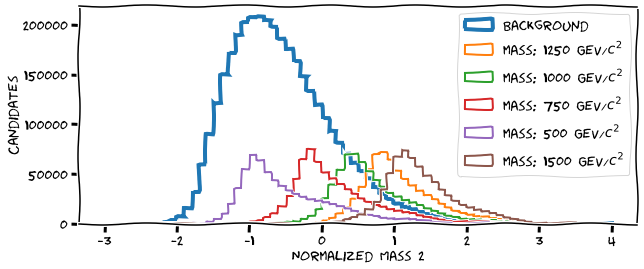

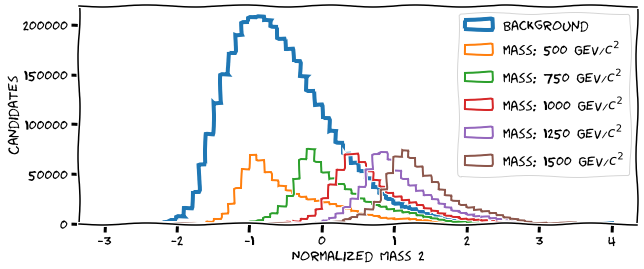

In [ ]:
#soluzione
with plt.xkcd():
  plt.figure(figsize=(10,4))
  bins = np.linspace(-3, 4, 71)

  plt.hist(m2 [label==0], bins=bins, label="Background", histtype='step', linewidth=4)
  for mass_value in mass_values:
    plt.hist(m2 [label==1][true_mass == mass_value], label=f"mass: {mass_value:.0f} GeV/$c^2$", bins=bins, histtype='step', linewidth=2)

  plt.xlabel("Normalized Mass 2")
  plt.ylabel("Candidates")
  plt.legend()
  plt.show()

## Esercizio 2 - Addestrare un Random Forest Classifier per il problema di classificazione

Prima di affrontare il problema del training di un algoritmo *parametrico*, consideriamo il caso del training di un classificatore che separi il segnale (per qualunque ipotesi di massa) da fondo.

### Esercizio 2.1 - Suddividere il campione in per *training* e *test*

Definire le variabili:
 * `train_idx` come un array di valori booleani di lunghezza pari alla lunghezza del dataset (7M righe) e con il 5% di valori veri.
 * `test_idx` come un array di valori booleani di lunghezza pari alla lunghezza del dataset (7M righe) e con il 5% di valori veri, _assicurandosi che per nessuna posizione possano essere veri contemporaneamente i valori di `test_idx` e `train_idx`_.

> **Nota bene! 5% non è un *typo***. 7 milioni di righe sono tante e il tempo di training e testing su colab è incompatibile con un esame di due ore. A casa, potete rigirare l'esercizio modificando queste percentuali.

In [ ]:
#soluzione
X = np.c_[pt1, pt2, m1, m2]
y = label

fraction_train = 0.05
fraction_test = 0.05

r = np.random.uniform(0, 1, len(X))

train_idx = r > 1-fraction_train
test_idx = r < fraction_test

Usando gli array `train_idx` e `test_idx`, costruire array che contengano *feature* e *label* del dataset di training (dove `train_idx` conteiene valori veri) e il dataset di test (dove `test_idx` contiene valori veri).

In [ ]:
#soluzione
train_X = X[train_idx]
train_y = y[train_idx]

test_X = X[test_idx]
test_y = y[test_idx]

### Esercizio 2.2 - Addestramento di una Random Forest per il problema di classificazione

Utilizzando la classe [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) definire ed addestrare una foresta decisionale in grado di separare segnale e fondo.

> **Suggerimento!** Per velocizzare addestramento e validazione, conviene limitare il numero di alberi nell'ensemble a 10.

In [ ]:
#soluzione
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(10)
classifier.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10)

### Esercizio 2.3 - Calcolo dell'area sottesa la curva ROC

Utilizzando la funzione [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) ottenere il valore dell'area sottesa dalla curva ROC.

In [ ]:
#soluzione
from sklearn.metrics import roc_auc_score
score = roc_auc_score (test_y, classifier.predict(test_X))
print (score)

0.7885845596536655


## Esercizio 2.4 - Calcolo dell'area sotto la curva ROC per ciascuna ipotesi di massa

Ripetere l'esercizio precedente, ma calcolando l'area sottesa dalla curva ROC per ciascun valore di massa $m_X$. Si noti che il valore di `true_mass` non è definito per il fondo, che è equivalente per tutte le ipotesi di segnale, e deve essere sempre incluso nella valutazione della performance del classificatore.


In [ ]:
#soluzione
scores = []
test_m = true_mass[test_idx]
for mass_value in mass_values:
  mask = (test_m == mass_value) | (test_y == 0)
  scores.append(roc_auc_score (test_y[mask], classifier.predict(test_X[mask])))


Il grafico dell'area sottesa dalla curva ROC in funzione della massa $m_X$, dovrebbe assomigliare al plot seguente.

Naturalmente, ci aspettiamo che per valori di $m_X$ più piccoli sia più difficile discriminare il segnale dal fondo e quindi la performance del classificatore sia peggiore.

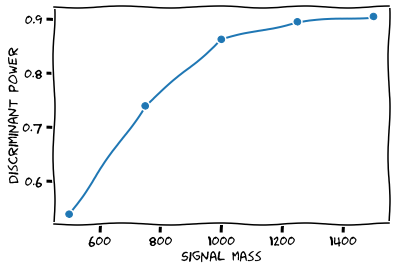

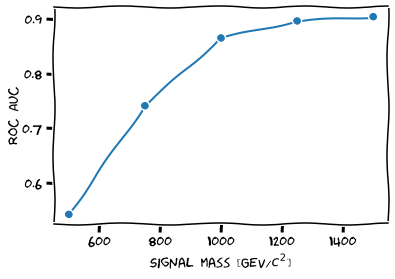

In [ ]:
#soluzione
with plt.xkcd():
  plt.plot (mass_values, scores, 'o-')
  plt.xlabel("Signal mass [GeV/$c^2$]")
  plt.ylabel("ROC AUC")
  plt.show()

## Esercizio 3 - Includere $m_X$ tra le feature

Ora, il problema di separare il segnale dal fondo è significativamente diverso per masse piccole, in cui le distribuzioni sono sostanzialmente sovrapponibili, e per masse grandi, dove la separazione è quasi completa. Di conseguenza addestrare un solo classificatore che tratti in modo del tutto agnostico il problema è probabilmente poco vantaggioso.

Possiamo cercare di fornire al classificatore l'informazione usata per simulare ciascun evento di segnale con l'idea di ottenere un *classificatore parametrico*, ossia in grado di definire una strategia di selezione in base ad uno, o più parametri, in questo caso $m_X$.

Il modo più semplice per parametrizzare il classificatore è utilizzare $m_X$ come *feature*, passandola al classificatore insieme a `pt1`, `pt2`, `m1` ed `m2`.

La variable $m_X$, però, è definita solo per gli eventi di *segnale*, e scegliere un valore costante per il fondo faciliterebbe il lavoro del classificatore che potrebbe distinguere il segnale dal fondo semplicemente in base al valore letto per $m_X$.

Invece, assegnamo alla *feature* $m_X$ per i valori di fondo un valore casuale, scelto tra i valori usati per il segnale, in modo da assicurare che le distribuzioni generatrici dei due campioni sia equivalente.

Per assegnare un valore casuale di $m_X$ ai campioni di fondo, potete usare questo frammento di codice:
```python
train_m = np.where(label[train_idx] == 1, true_mass[train_idx], np.random.choice(true_mass[label==1], np.count_nonzero(train_idx)))
test_m = np.where(label[test_idx] == 1, true_mass[test_idx], np.random.choice(true_mass[label==1], np.count_nonzero(test_idx)))
```

In [ ]:
#soluzione
train_m = np.where(label[train_idx] == 1, true_mass[train_idx], np.random.choice(true_mass[label==1], np.count_nonzero(train_idx)))
test_m = np.where(label[test_idx] == 1, true_mass[test_idx], np.random.choice(true_mass[label==1], np.count_nonzero(test_idx)))

### Esercizio 3.1 - Addestrare una Random Forest usando $m_X$ come feature

Si addestri un nuovo classifier, identico al precedente per algoritmo e iperparametri, ma aggiungendo il valore di $m_X$ (ossia `train_m`) tra le *feature*.

In [ ]:
#soluzione
p_classifier = RandomForestClassifier(10)
p_classifier.fit(np.c_[train_X, train_m], train_y)

RandomForestClassifier(n_estimators=10)

### Esercizio 3.2 - Calcolo dell'area sotto la curva ROC per ciascuna ipotesi di massa

Ripetere il calcolo dell'area sottesa dalla curva ROC per il nuovo classificatore e confrontare il risultato con quello ottenuto nell'esercizio 2.



In [ ]:
#soluzione
p_scores = []
for mass_value in sorted(mass_values):
  mask = (test_m == mass_value) | (test_y == 0)
  p_scores.append(roc_auc_score (test_y[mask], p_classifier.predict(np.c_[test_X, test_m][mask])))

Dal confronto, dovrebbe emergere una figura analoga alla seguente.

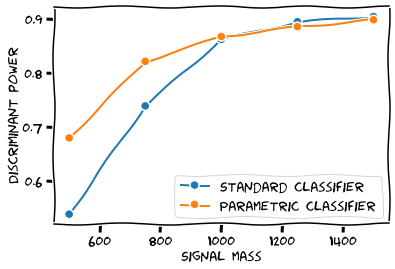

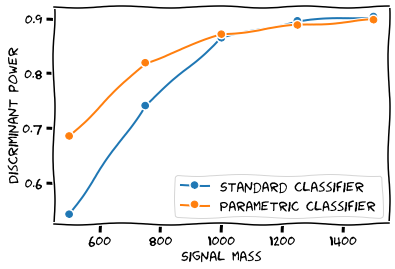

In [ ]:
#soluzione
with plt.xkcd():
  plt.plot (sorted(mass_values), scores, 'o-', label="Standard classifier")
  plt.plot (sorted(mass_values), p_scores, 'o-', label="Parametric classifier")
  plt.xlabel("Signal mass")
  plt.ylabel("Discriminant power")
  plt.legend()
  plt.show()

# Conclusioni

In questo tema abbiamo considerato il problema di classificazione tra un fondo ed un segnale che dipende da un parametro, per esempio $m_X$.
Il classificatore ottenuto ignorando la dipendenza delle distribuzioni di input da $m_X$ ha performance peggiori di quelle ottenute con un classificatore *parametrico* che possa definire la strategia di selezione sulla base del valore di $m_X$.